In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk 
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

/home/k123/env/python2.7.12/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization



In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
#     return Conv2D(f, kernel_initializer = conv_init, *a, **k)
    return Conv2D(f, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
#         input_a = Input(shape=(None, None, nc_in))
        input_a = Input(shape=(128, 128, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
lambda_ = 10 if use_lsgan else 100
# lambda_ = 1 if use_lsgan else 10 # for face2emoji 

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [9]:
from keras.utils.vis_utils import model_to_dot

def plot_model_png(model, path):
    model_img = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='png'))
    with open(path, 'wb' ) as f:
        f.write(model_img)
    

In [10]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
# netDA.summary()
# plot_model_png(netDA, './D.png')


In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
# SVG(model_to_dot(netGA, show_shapes=True).create(prog='dot', format='svg'))
# plot_model_png(netGA, './G.png')
# netGA.summary()



In [12]:
from keras.optimizers import RMSprop, SGD, Adam
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)


In [13]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [14]:
loss_G = loss_GA+loss_GB+lambda_*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

netD_opt = Adam(lr=lrD, beta_1=0.5)
training_updates = netD_opt.get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)

netG_opt = Adam(lr=lrD, beta_1=0.5)
training_updates = netG_opt.get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)




In [15]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
#     load image with BILINEAR resizing, and crop the central region. 143*143 -> 128*128
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
#     normalize,[0,255] -> [-1,1]
    arr = np.array(im)/255. * 2 -1
#     print 'im',im
#     print arr
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
#     horizontal flip
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
# dataset = "horse2zebra"
# dataset = "face2emoji"
# dataset = 'face2president'
# dataset = "president2coach"
dataset = 'annie2coach'
# dataset = "lfw2coach"
train_A = load_data('CycleGAN/{}/trainA/*.jpg'.format(dataset))
train_B = load_data('CycleGAN/{}/trainB/*.jpg'.format(dataset))
test_A = load_data('CycleGAN/{}/testA/*.jpg'.format(dataset))
test_B = load_data('CycleGAN/{}/testB/*.jpg'.format(dataset))
assert len(train_A) and len(train_B)

In [16]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

(6, 128, 128, 3)


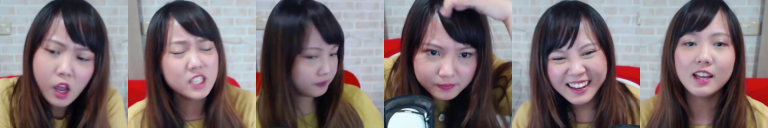

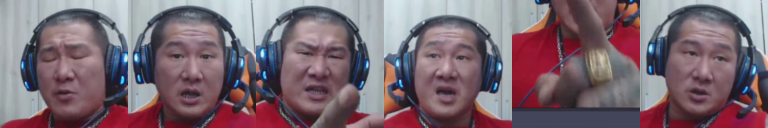

In [17]:
from IPython.display import display
# import matplotlib.pyplot as plt
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
#     
#     im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    display(Image.fromarray(int_X))
#     plt.imshow(int_X,aspect='auto')
#     plt.imshow(int_X)
#     plt.show()
    return int_X

# 
train_batch = minibatchAB(train_A, train_B, 6)
_, A, B = next(train_batch)
print A.shape
# print A
showX(A)
showX(B)
del train_batch, A, B




In [18]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    return showX(arr, 3)

In [19]:
from keras.models import save_model, load_model
from os.path import join
import numpy as np
import os

def save_model_tmp(model, path):
    save_model(model, join('./tmp.hdf5'))
    
    
    save_model(model, path)
    

def save(dataset_name, with_opt):
    # save models
    
    dir_path = join('./','models',dataset_name)
    if not os.path.isdir(join('./','models')):
        os.mkdir(join('./','models'))
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
        

    save_model_tmp(netDA, join(dir_path,'netDA.hdf5'))
    save_model_tmp(netDB, join(dir_path,'netDB.hdf5'))
    save_model_tmp(netGA, join(dir_path,'netGA.hdf5'))
    save_model_tmp(netGB, join(dir_path,'netGB.hdf5'))
#     save optimizer
    if with_opt:
        training_optimizers = [netD_opt, netG_opt]
        save_optimizers(training_optimizers, dataset_name)
    
    

def load(dataset_name, with_opt):
    # load model
    
    print 'load model from %s, with optimizer weights : %s' % (dataset_name, with_opt)
    
    dir_path = join('./','models',dataset_name)
    
    netDA.load_weights(join(dir_path,'netDA.hdf5'))
    netDB.load_weights(join(dir_path,'netDB.hdf5'))
    netGA.load_weights(join(dir_path,'netGA.hdf5'))
    netGB.load_weights(join(dir_path,'netGB.hdf5'))
#     netDA = load_model(join(dir_path,'netDA.hdf5'))
#     netDB = load_model(join(dir_path,'netDB.hdf5'))
#     netGA = load_model(join(dir_path,'netGA.hdf5'))
#     netGB = load_model(join(dir_path,'netGB.hdf5'))
    if with_opt:
        training_optimizers = [netD_opt, netG_opt]
        load_optimizers(training_optimizers, dataset_name)
    
def save_optimizers(opt_list, dataset_name):
    netD_opt, netG_opt = opt_list
    root_path = make_path(join('./','models',dataset,'Adam_opt'))
    
    opt_path = make_path(join(root_path, 'netD_opt'))
    save_opt_weights(opt_path, netD_opt)
    
    opt_path = make_path(join(root_path, 'netG_opt'))
    save_opt_weights(opt_path, netG_opt)
    
    
def load_optimizers(opt_list, dataset_name):
    netD_opt, netG_opt = opt_list
    root_path = join('./','models',dataset,'Adam_opt')

    opt_path = join(root_path, 'netD_opt')
    load_opt_weights(opt_path, netD_opt)
    opt_path = join(root_path, 'netG_opt')
    load_opt_weights(opt_path, netG_opt)
    
    
def make_path(path):
    if not os.path.isdir(path):
        os.mkdir(path)
    return path


def save_opt_weights(path, opt):
    wei = opt.get_weights()
    for i,w in enumerate(wei):
        out_path = join(path,'%d.opt' % i)
        with open(out_path, 'wb') as f:
            np.save(f, w)
def load_opt_weights(path, opt):
    N =  len([f for f in os.listdir(path) if f.endswith('.opt')])
    wei = []
    for i in range(N):
        out_path = join(path,'%d.opt' % i)
        with open(out_path, 'rb') as f:
            w = np.load(f)
        wei.append(w)
    opt.set_weights(wei)





In [20]:
import time
import os
from os.path import join
from IPython.display import clear_output
t0 = time.time()
img_dir = join('.','buf_data','imgs')
niter = 350
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 20
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)
test_batch = minibatchAB(test_A, test_B, batchSize)
next(test_batch)

# load(dataset, with_opt=True)
with open('./log','w') as f:
    f.write('start training model with dataset : %s' % dataset)
print 'start training model with dataset : %s' % dataset
while epoch < niter: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
#         clear_output()
        log = '[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f, save model, time consume : %.2f iter : %d\n '  % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters, errGA_sum/display_iters, errGB_sum/display_iters, \
           errCyc_sum/display_iters, time.time()-t0, gen_iterations) 
        
        print(log)
#         train
        _, A, B = train_batch.send(4)
        train_sample = showG(A,B)
        img = Image.fromarray(train_sample)
        img.save(join(img_dir,'train_%d.jpg' % gen_iterations))
#         test
        _, A, B = test_batch.send(4)
        test_sample = showG(A,B) 
        img = Image.fromarray(test_sample)
        img.save(join(img_dir,'test_%d.jpg' % gen_iterations))
#         
        save(dataset, with_opt=True)
        if gen_iterations == 20000:
            save(dataset+'20000', with_opt=True)
            
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        with open('./log','a') as f:
            f.write(log)
            
print 'done'
            

start training model with dataset : annie2coach
[0/350][20] Loss_D: 1.334922 1.457643 Loss_G: 3.679334 5.600145 loss_cyc 0.880539, save model, time consume : 32.76 iter : 20
 


IOError: cannot identify image file 'CycleGAN/annie2coach/trainA/79.jpg'

# 